In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import sklearn
import skimage
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2*1024)])
    except RuntimeError as e:
        print(e)
    
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, InputLayer
from tensorflow.keras.optimizers import RMSprop
import gym
import matplotlib.pyplot as plt
import sklearn
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

#This checks early execution for tensorflow 2
tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()
print('executing eagerly? ',tf.executing_eagerly())
print('\nGPUs available ',tf.config.list_physical_devices('GPU'))

executing eagerly?  True

GPUs available  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from collections import deque

In [16]:
def epsilon_greedy_policy(state,model,epsilon=0):
    if np.random.uniform() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

def sample_experiences(batch_size,replay_buffer):
    indices = np.random.randint(len(replay_buffer),size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    
    return states, actions, rewards, next_states, dones

def play_one_step(env, state,model,replay_buffer, epsilon):
    action = epsilon_greedy_policy(state,model,epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state,action,reward,next_state,done))
    return next_state, reward, done, info


def make_model(n_outputs=2):
    model = Sequential([
        Dense(32,activation='relu',input_shape=input_shape),
        Dense(32,activation='relu'),
        Dense(n_outputs)
    ]) 
    return model


def training_step(batch_size,replay_buffer,model,target,discount_factor=0.95,loss_fn=keras.losses.mean_squared_error,
                 optimizer=keras.optimizers.Adam(lr=1e-3)):
    experiences = sample_experiences(batch_size,replay_buffer)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = target.predict(next_states)
    max_next_Q_values = np.max(next_Q_values,axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values,Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    
def generate_gif(frame_number, frames_for_gif, reward, path):
    """
        Args:
            frame_number: Integer, determining the number of the current frame
            frames_for_gif: A sequence of (210, 160, 3) frames of an Atari game in RGB
            reward: Integer, Total reward of the episode that es ouputted as a gif
            path: String, path where gif is saved
    """
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_number, reward)}', 
                    frames_for_gif, duration=1/30)    


In [14]:
env = gym.make('CartPole-v0')
env.reset()
obs = env.render(mode='rgb_array')

In [15]:
obs

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [18]:
batch_size=32
discount_factor = 0.95
optimizer = keras.optimizers.RMSprop(lr=25e-3)
loss_fn = keras.losses.mean_squared_error

env = gym.make('CartPole-v0')
input_shape = [4]
n_outputs = 2

replay_buffer = deque(maxlen=int(1e6))
reward_history = []
model = make_model()
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())
best_score = 0

for episode in range(1000):
    if episode%50 == 0:
        print(episode)
    obs = env.reset()
    
    for step in range(200):
        #print('step')
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env,obs,model,replay_buffer,epsilon)
        if done:
            break
            
    reward_history.append(step)
    
    if step > best_score:
        best_weights = model.get_weights()
        model.save_weights('Pong_Best_Weights.h5')
        best_score = step
    if episode > 49:
        training_step(batch_size,replay_buffer,model,target,discount_factor,loss_fn,optimizer)
        
        if episode%50==0:
            target.set_weights(model.get_weights())

0
50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [24]:
best_score

199

In [23]:
model.set_weights(best_weights)

In [45]:
frames= []
import time
obs = env.reset()
current_frame = 0
for step in range(10000):
    
    frames.append(env.render(mode='rgb_array'))
    obs,reward,done,info = play_one_step(env,obs,model,replay_buffer,epsilon)
    current_frame += 1
    if done:
        break
env.close()

In [46]:
current_frame

200

In [31]:
import imageio
generate_gif(0,frames,current_frame,'cart_pole_example')

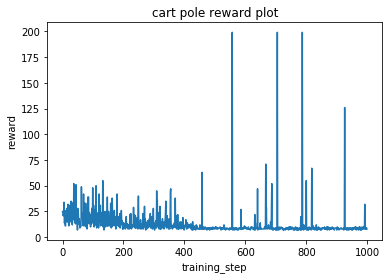

In [32]:
plt.plot(reward_history)
plt.xlabel('training_step')
plt.ylabel('reward')
plt.title('cart pole reward plot')
plt.savefig('cartpole.png')